In [1]:
from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg16
from keras import backend as K

Using TensorFlow backend.


In [2]:
base_image_path = 'Content_image.jpg'
style_reference_image_path = 'Style_image.jpg'

In [3]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [6]:
# util function to open, resize and format pictures into appropriate tensors

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img




# util function to convert a tensor into a valid image

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [8]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [9]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,style_reference_image,combination_image], axis=0)

In [11]:
# build the VGG16 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg16.VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [12]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [13]:
content_weight = 1
style_weight= 0.1
total_variation_weight = 1e-04

In [14]:
# compute the neural style loss
# first we need to define 4 util functions

In [15]:
# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram



# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))



# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return K.sum(K.square(combination - base))



# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [16]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [17]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [18]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [19]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(101):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    if i%10==0:
        img = deprocess_image(x.copy())
        fname = 'generated_image' + '_at_iteration_%d.png' % i
        imsave(fname, img)
        print('Image saved as', fname)
    end_time = time.time()
print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.10247e+09
Image saved as generated_image_at_iteration_0.png
Start of iteration 1
Current loss value: 7.89247e+08
Start of iteration 2
Current loss value: 4.63005e+08
Start of iteration 3
Current loss value: 2.59809e+08
Start of iteration 4
Current loss value: 1.88724e+08
Start of iteration 5
Current loss value: 1.6471e+08
Start of iteration 6
Current loss value: 1.48693e+08
Start of iteration 7
Current loss value: 1.38959e+08
Start of iteration 8
Current loss value: 1.34766e+08
Start of iteration 9
Current loss value: 1.26964e+08
Start of iteration 10
Current loss value: 1.02373e+08
Image saved as generated_image_at_iteration_10.png
Start of iteration 11
Current loss value: 9.31801e+07
Start of iteration 12
Current loss value: 8.55373e+07
Start of iteration 13
Current loss value: 8.25704e+07
Start of iteration 14
Current loss value: 7.73004e+07
Start of iteration 15
Current loss value: 7.50112e+07
Start of iteration 16
Current loss value: 7.24

In [20]:
K.clear_session()

In [21]:
from IPython.display import Image

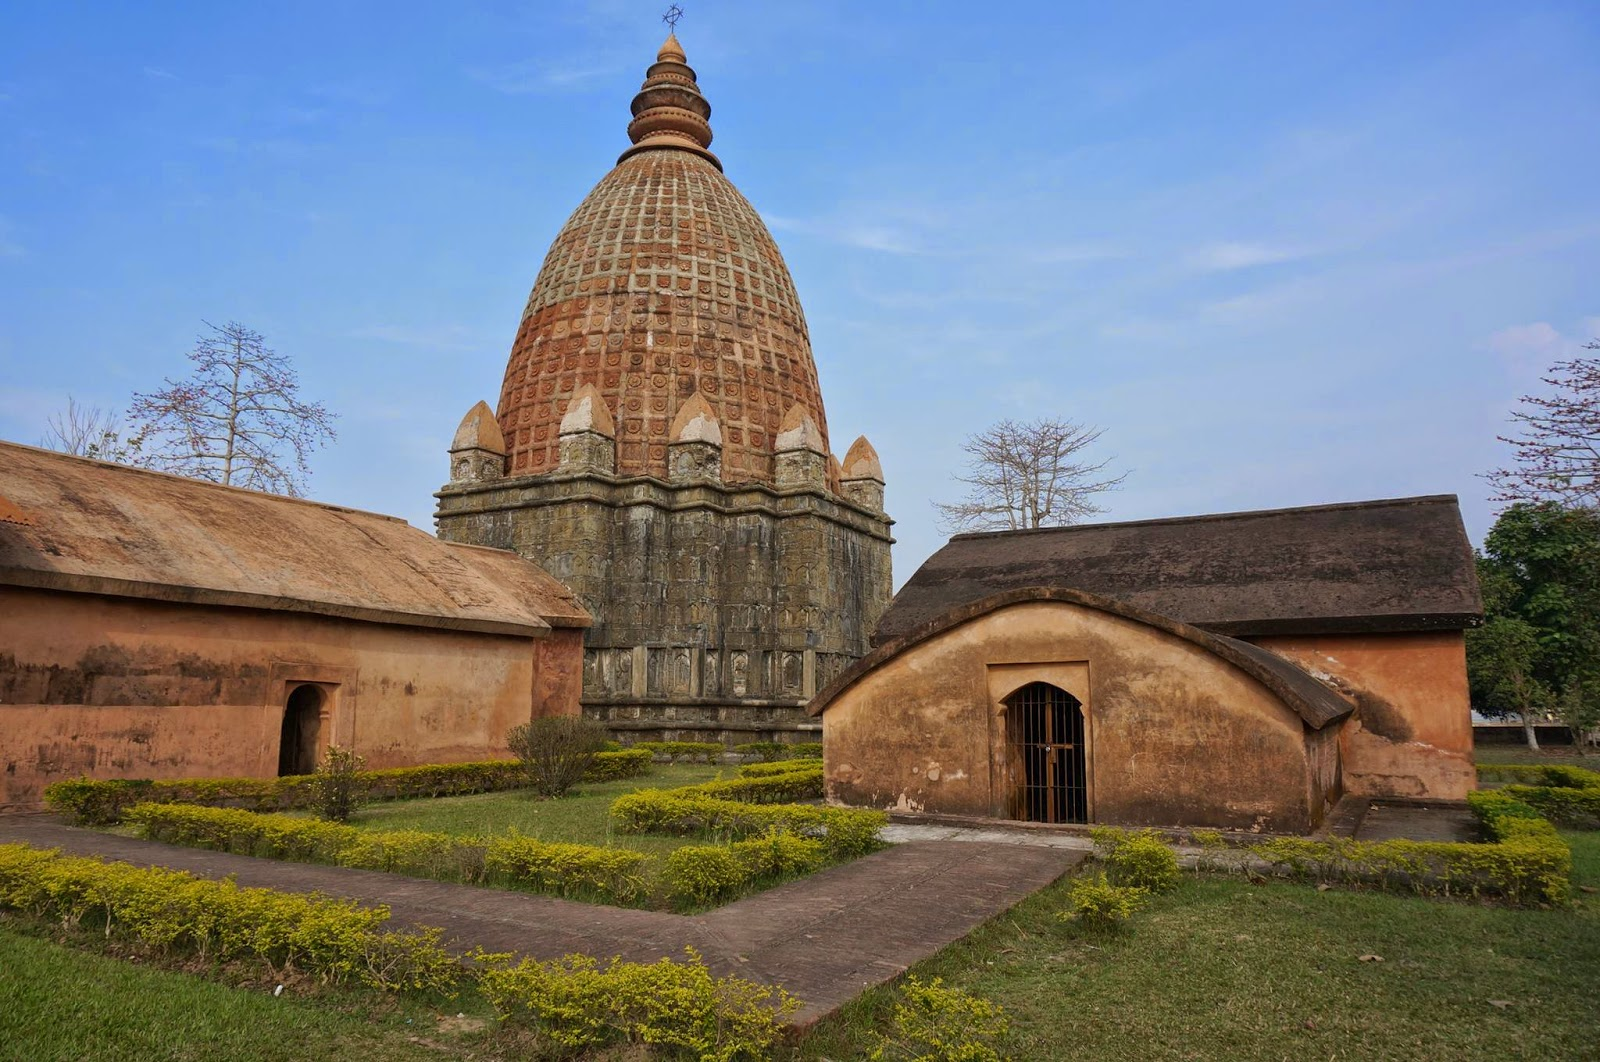

In [22]:
#Content_image
Image("Content_image.jpg")

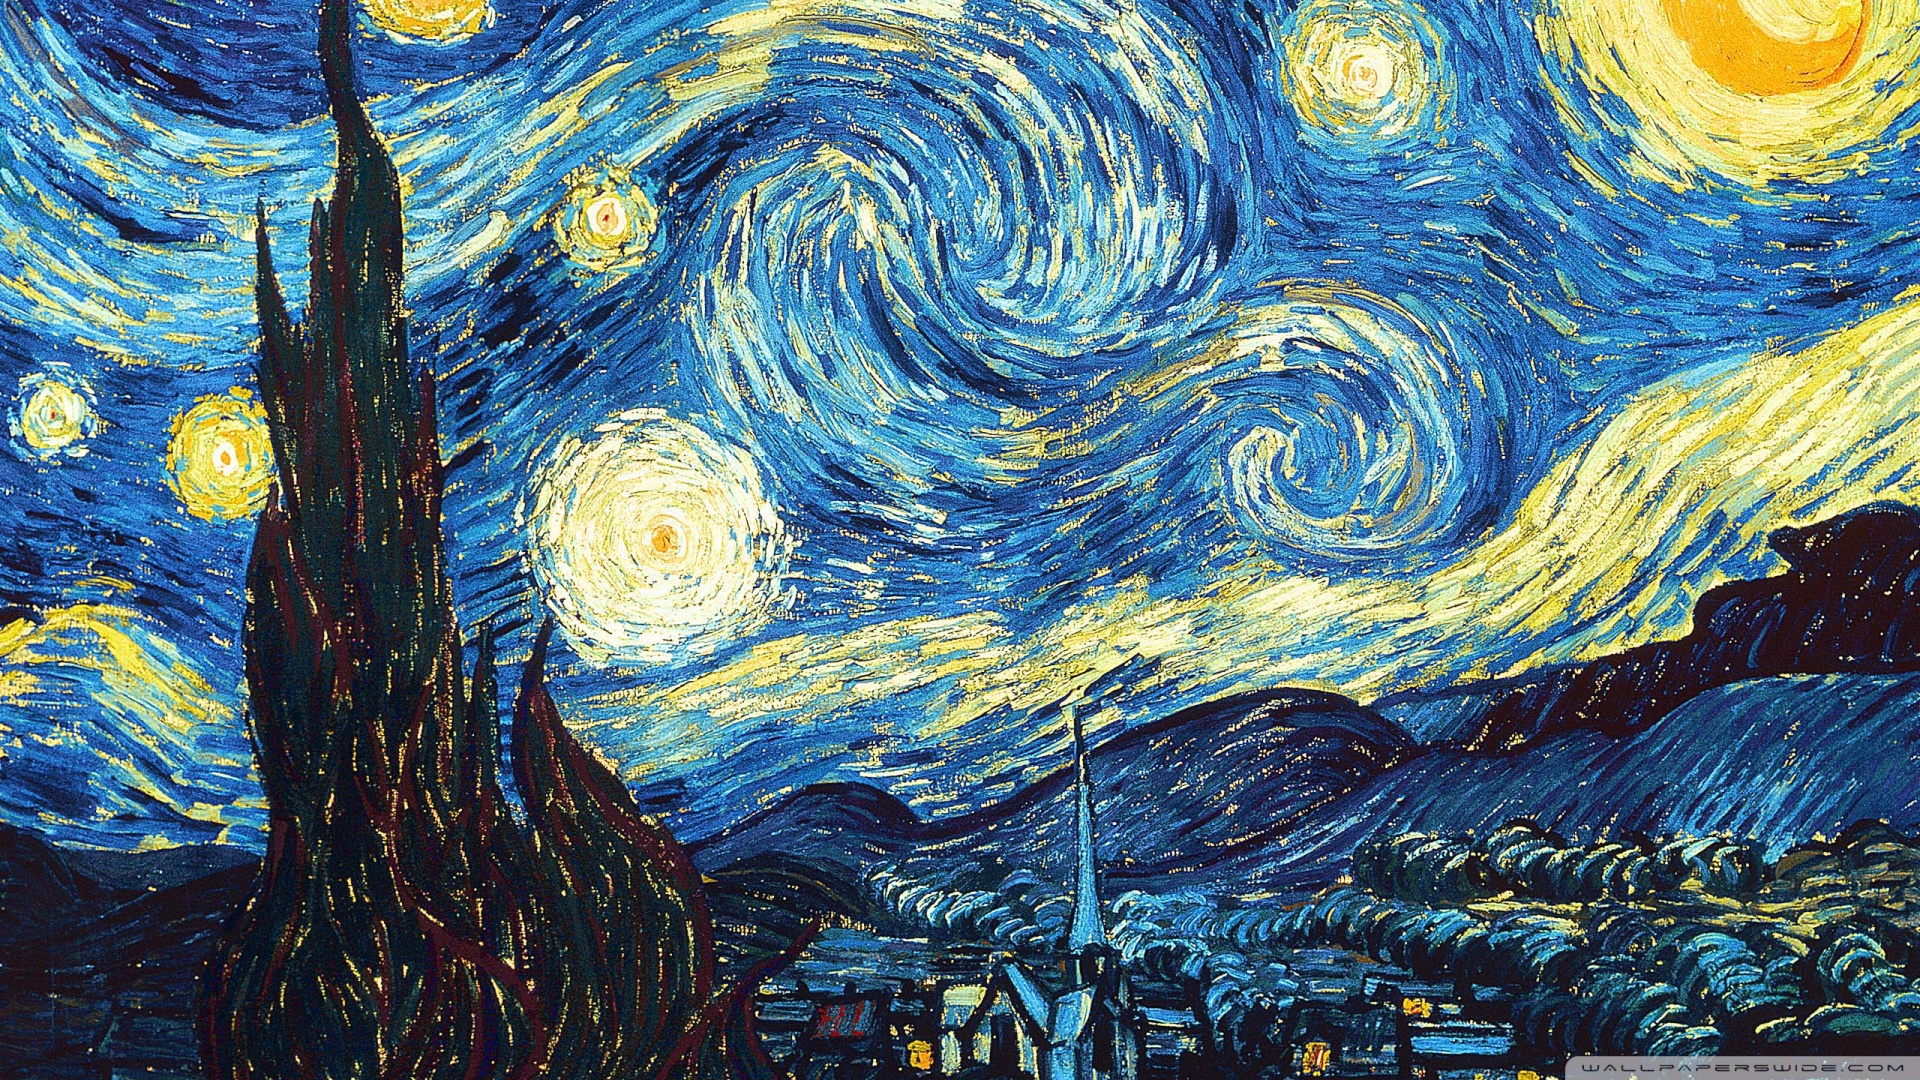

In [23]:
#style_image
Image("Style_image.jpg")

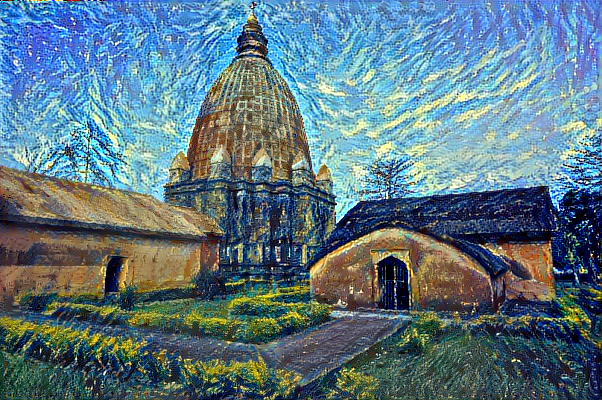

In [24]:
#final_generated_image
Image("generated_image_at_iteration_100.png")